<a href="https://colab.research.google.com/github/CallmeQuant/Studying-Notebook/blob/main/Customer_Churn_Analysis_Survival_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Environment Setups**

In [1]:
import sys
print("User Current Version:-", sys.version)

User Current Version:- 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


In [2]:
from google.colab import drive
drive.mount("/content/drive")
from google.colab import files

Mounted at /content/drive


## **Installing Modules**

In [3]:
%%capture
!pip install dtype_diet
!pip install scikit-plot
# packages for survival analysis
!pip install lifelines
!pip install pysurvival
!pip install lifetimes
!pip install dtype_diet
!pip install optuna

## **Importing Libraries**

In [4]:
import pandas as pd
import numpy as np
from dtype_diet import report_on_dataframe, optimize_dtypes
from typing import *

from scipy.stats import norm
import statsmodels.api as st
from sklearn.preprocessing import LabelEncoder

import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

# import pysurvival
# from pysurvival.datasets import Dataset
# from pysurvival.utils.display import correlation_matrix, compare_to_actual, integrated_brier_score, create_risk_groups
# from pysurvival.utils.metrics import concordance_index
# from pysurvival.models.survival_forest import ConditionalSurvivalForestModel
# Plotting params
plot_params = {
    "font.size": 10,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.grid": False,
    "grid.linestyle": "-",
    "grid.linewidth": 0.5,
    "axes.spines.top": True,
    "axes.spines.right": True,
    "axes.labelsize": 12,
    "axes.labelweight": "bold",
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.titlesize": 12,
    "axes.titleweight": "bold",
    "figure.dpi": 150,
    "figure.constrained_layout.use": True,
    "figure.autolayout": False}

# plt.style.use("ggplot")
plt.rcParams.update(plot_params)
# plt.rcParams["font.size"] = 15
# # plt.rcParams['axes.facecolor'] = 'white'
# # Set the background color to white
# plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams['axes.facecolor'] = 'white'

# # Only show major gridlines
# plt.rcParams['axes.grid'] = True
# plt.rcParams['grid.linestyle'] = '-'
# plt.rcParams['grid.linewidth'] = 0.5

# # Only show left and bottom axes
# plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.spines.right'] = False
COLORS = list(sns.color_palette())
import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

## **Data Loading**

In [5]:
# Printing information function
def print_info(info, *args):
  print(
      '-'*len(info),
      info,
      '-'*len(info),
      *args,
      sep = '\n'
  )

In [6]:
df = pd.read_csv("drive/My Drive/data/telco_cus_churn_data.csv")

From our analysis in the previous EDA and Modeling [notebook](https://github.com/CallmeQuant/Studying-Notebook/blob/main/Customer_Churn_Analysis.ipynb), we identify features which are crucial to the churn model

In [7]:
le = LabelEncoder()
# Drop duplicates
df.drop_duplicates(inplace=True)
# Drop null values
df['TotalCharges'] = df["TotalCharges"].replace(" ", np.nan)
df['TotalCharges'] = df["TotalCharges"].astype(float)
df['TotalCharges'] = df['TotalCharges'].fillna(0)
# Optimizing dataframes
proposed_df = report_on_dataframe(df, unit="MB")
opt_df = optimize_dtypes(df, proposed_df)
print_info("Dataframe Memory Optimize",
           f'Original df memory: {df.memory_usage(deep=True).sum()/1024/1024} MB',
           f'Propsed df memory: {opt_df.memory_usage(deep=True).sum()/1024/1024} MB',
           f'Reduction proportion: {100 * (df.memory_usage(deep=True).sum()/1024/1024) / (opt_df.memory_usage(deep=True).sum()/1024/1024)}%')

print('')
print(opt_df.info())

# Encodingg target variable
opt_df['Churn'] = le.fit_transform(df['Churn'])

# Define variable for survival analysis
time = opt_df['tenure']
event = opt_df['Churn']
# Drop unnecessary features based on previous analysis
df1 = opt_df.copy(deep = True)
df1.drop(columns = ['customerID', 'PhoneService', 'gender','StreamingTV','StreamingMovies','MultipleLines','InternetService'], inplace = True)

cat_feats = [i for i in list(df1.columns) if i not in list(df1.describe().columns)]

# survival_df = pd.get_dummies(df1, columns = cat_feats, drop_first= True)
# survival_df = st.add_constant(survival_df, prepend=False)

-------------------------
Dataframe Memory Optimize
-------------------------
Original df memory: 7.473172187805176 MB
Propsed df memory: 0.7364768981933594 MB
Reduction proportion: 1014.7191590309899%

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   int8    
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   tenure            7043 non-null   int8    
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport  

# **Kaplan-Meier Curve for Categorical Features**

In [8]:
#Create a KaplanMeier object, imported from lifelines
kmf = KaplanMeierFitter()

In [9]:
def plot_categorical_survival(feature, t=time, event=event, df=df1, ax=None):
    for cat in df[feature].unique():
        idx = df[feature] == cat
        kmf.fit(time[idx], event_observed=event[idx], label=cat)
        kmf.plot(ax=ax, label=cat)

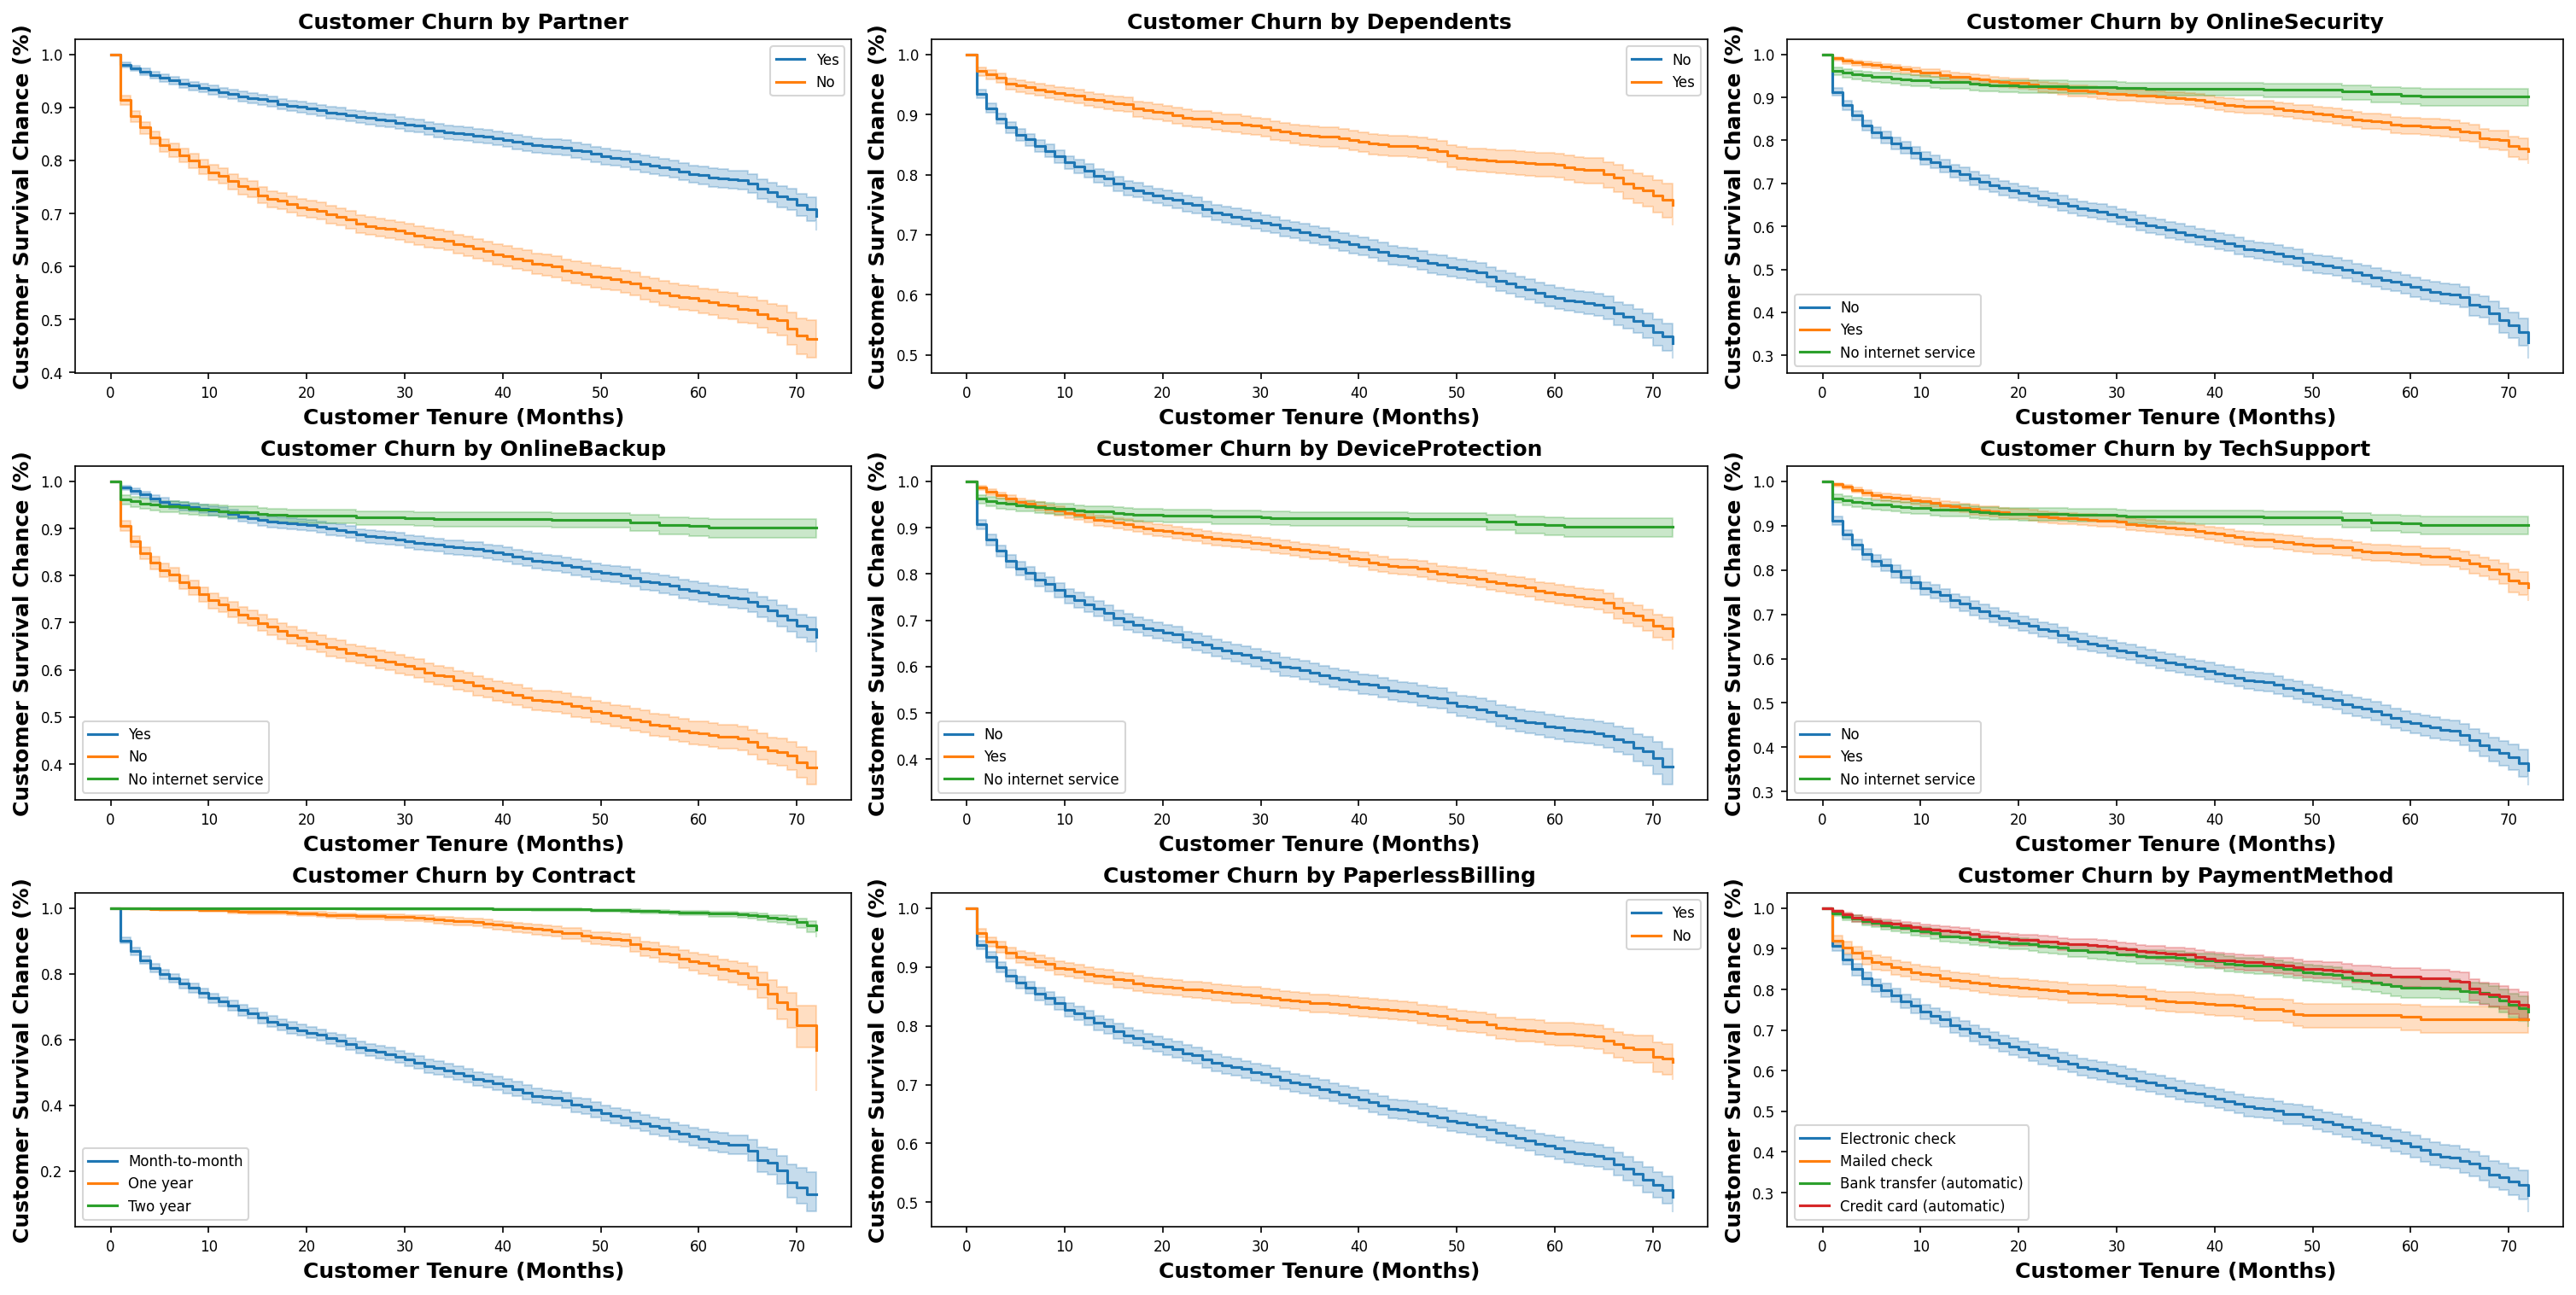

In [10]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(20,10))
for feat, ax in zip(cat_feats, axes.flatten()):
  plot_categorical_survival(feature = feat, ax=ax)
  ax.set_title('Customer Churn by ' + str(feat))
  ax.set_xlabel('Customer Tenure (Months)')
  ax.set_ylabel('Customer Survival Chance (%)')

# **Statistically compare two populations - Logrank Test**

In [11]:
def log_rank_test(feature, df, info = True, threshold = 0.05):
  unique_cat = df[feature].unique()
  num_unique_cat = len(unique_cat)

  if num_unique_cat == 2:
    cat1, cat2 = unique_cat
    idx1 = df[feature] == cat1
    idx2 = df[feature] == cat2
    results = logrank_test(time[idx1], time[idx2], event[idx1], event[idx2])
  else:
    results = multivariate_logrank_test(time, df[feature], event)

  if info:
    decision = 'Reject' if results.p_value <= threshold else 'Fail to reject'
    print('')
    print_info('Intepretation of Test Statistic',
               f'Feature: {feature}',
               f'p-value: {round(results.p_value, 5)}',
               f'Test statistic: {results.test_statistic}',
               f'Null Hypothesis (the survival times of groups come from the same distribution): {decision}')
    print('')
  return results.print_summary()


In [12]:
for feat in cat_feats:
  log_rank_test(feat, df1)


-------------------------------
Intepretation of Test Statistic
-------------------------------
Feature: Partner
p-value: 0.0
Test statistic: 423.54308160011647
Null Hypothesis (the survival times of groups come from the same distribution): Reject



<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         423.54 <0.005    310.21


-------------------------------
Intepretation of Test Statistic
-------------------------------
Feature: Dependents
p-value: 0.0
Test statistic: 232.69904170889183
Null Hypothesis (the survival times of groups come from the same distribution): Reject



<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         232.70 <0.005    172.12


-------------------------------
Intepretation of Test Statistic
-------------------------------
Feature: OnlineSecurity
p-value: 0.0
Test statistic: 1013.8648560017084
Null Hypothesis (the survival times of groups come from the same distribution): Reject



<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
        1013.86 <0.005    731.35


-------------------------------
Intepretation of Test Statistic
-------------------------------
Feature: OnlineBackup
p-value: 0.0
Test statistic: 821.3388247397763
Null Hypothesis (the survival times of groups come from the same distribution): Reject



<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         821.34 <0.005    592.47


-------------------------------
Intepretation of Test Statistic
-------------------------------
Feature: DeviceProtection
p-value: 0.0
Test statistic: 763.5064140746797
Null Hypothesis (the survival times of groups come from the same distribution): Reject



<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         763.51 <0.005    550.75


-------------------------------
Intepretation of Test Statistic
-------------------------------
Feature: TechSupport
p-value: 0.0
Test statistic: 989.5601461766983
Null Hypothesis (the survival times of groups come from the same distribution): Reject



<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         989.56 <0.005    713.82


-------------------------------
Intepretation of Test Statistic
-------------------------------
Feature: Contract
p-value: 0.0
Test statistic: 2352.8725382593416
Null Hypothesis (the survival times of groups come from the same distribution): Reject



<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
        2352.87 <0.005       inf


-------------------------------
Intepretation of Test Statistic
-------------------------------
Feature: PaperlessBilling
p-value: 0.0
Test statistic: 189.511486090142
Null Hypothesis (the survival times of groups come from the same distribution): Reject



<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         189.51 <0.005    140.82


-------------------------------
Intepretation of Test Statistic
-------------------------------
Feature: PaymentMethod
p-value: 0.0
Test statistic: 865.2394631323974
Null Hypothesis (the survival times of groups come from the same distribution): Reject



<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         865.24 <0.005    619.58

# **Regression Model - Cox Proportional Hazard Model**

## **Prepare Data for Regression**

In [13]:
def prepare_df_regression(original_df, categorical_features):
  regression_df = original_df.copy()
  binary_feats = []
  no_internet_feats = []
  onehot_encode_feats = []
  val = 'No internet service'
  for cat in categorical_features:
    if regression_df[cat].nunique() == 2:
      binary_feats.append(cat)
    elif any(val in subcat for subcat in list(regression_df[cat].unique())):
      no_internet_feats.append(cat)
    else:
      onehot_encode_feats.append(cat)

  for cat in binary_feats:
    regression_df[cat] = regression_df[cat].apply(lambda x: 0 if x == "No" else 1)

  for cat in no_internet_feats:
    regression_df[cat] = regression_df[cat].map({'No internet service': 0, 'No': 0, 'Yes': 1})

  regression_df = pd.get_dummies(regression_df,
                                 columns=onehot_encode_feats,
                                 drop_first = True)

  print_info('Summary of Features',
             f'Binary features: {binary_feats}',
             f'Features with No internet serice option: {no_internet_feats}',
             f'One hot encoding features: {onehot_encode_feats}')

  return regression_df

In [14]:
regression_df = prepare_df_regression(df1, cat_feats)

-------------------
Summary of Features
-------------------
Binary features: ['Partner', 'Dependents', 'PaperlessBilling']
Features with No internet serice option: ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
One hot encoding features: ['Contract', 'PaymentMethod']


## **Train Test Split**

In [15]:
train_size = int(len(regression_df) * 0.8)
train_regression = regression_df[:train_size]
test_regression = regression_df[train_size:]

## **Fitting Model**

In [16]:
from lifelines import CoxPHFitter

In [17]:
# cox_params = {
#     'base_line_estimation_method': 'breslow', ''
# }
cph = CoxPHFitter()
cph.fit(train_regression, duration_col='tenure', event_col='Churn', show_progress=False)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 5634 total observations, 4146 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 5634
number of events observed = 1488
   partial log-likelihood = -9778.12
         time fit was run = 2023-10-04 13:19:59 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
SeniorCitizen                           0.04       1.04       0.06            -0.08             0.16                 0.92                 1.18
Partner                                -0.18       0.83       0.06            -0.31            -0.06                 0.74                 0.94
Dependents                             -0.16       0.85       0.08            -0.31            -0.01                 0.73                 0.99
OnlineSecurity                         -0.28       0.76       0.07            -0.42            -0.13                 0.65                 0.87
OnlineBackup                           -0.19       0.83       0.06            -0.31            -0.07                 0.73                 0.93
DeviceProtection                       -0.08       0.92       0.06            -0.20             0.04                 0.82                 1.04
TechSupport                            -0.25       0.78       0.07            -0.39            -0.10                 0.68                 0.90
PaperlessBilling                        0.19       1.21       0.06             0.06             0.32                 1.07                 1.37
MonthlyCharges                          0.05       1.05       0.00             0.05             0.06                 1.05                 1.06
TotalCharges                           -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Contract_One year                      -1.64       0.19       0.11            -1.87            -1.42                 0.15                 0.24
Contract_Two year                      -4.42       0.01       0.22            -4.85            -4.00                 0.01                 0.02
PaymentMethod_Credit card (automatic)   0.03       1.03       0.10            -0.17             0.24                 0.85                 1.27
PaymentMethod_Electronic check          0.43       1.54       0.08             0.27             0.59                 1.31                 1.81
PaymentMethod_Mailed check              0.51       1.67       0.10             0.32             0.70                 1.38                 2.02

                                        cmp to      z      p   -log2(p)
covariate                                                              
SeniorCitizen                             0.00   0.62   0.53       0.91
Partner                                   0.00  -2.97 <0.005       8.41
Dependents                                0.00  -2.04   0.04       4.60
OnlineSecurity                            0.00  -3.76 <0.005      12.53
OnlineBackup                              0.00  -3.07 <0.005       8.89
DeviceProtection                          0.00  -1.32   0.19       2.42
TechSupport                               0.00  -3.32 <0.005      10.10
PaperlessBilling                          0.00   2.96 <0.005       8.36
MonthlyCharges                            0.00  29.10 <0.005     615.84
TotalCharges                              0.00 -36.54 <0.005     968.76
Contract_One year                         0.00 -14.36 <0.005     152.99
Contract_Two year                         0.00 -20.56 <0.005     309.48
PaymentMethod_Credit card (automatic)     0.00   0.33   0.74       0.44
PaymentMethod_Electronic check            0.00   5.21 <0.005      22.32
PaymentMethod_Mailed check                0.00   5.2

<Axes: xlabel='log(HR) (95% CI)'>

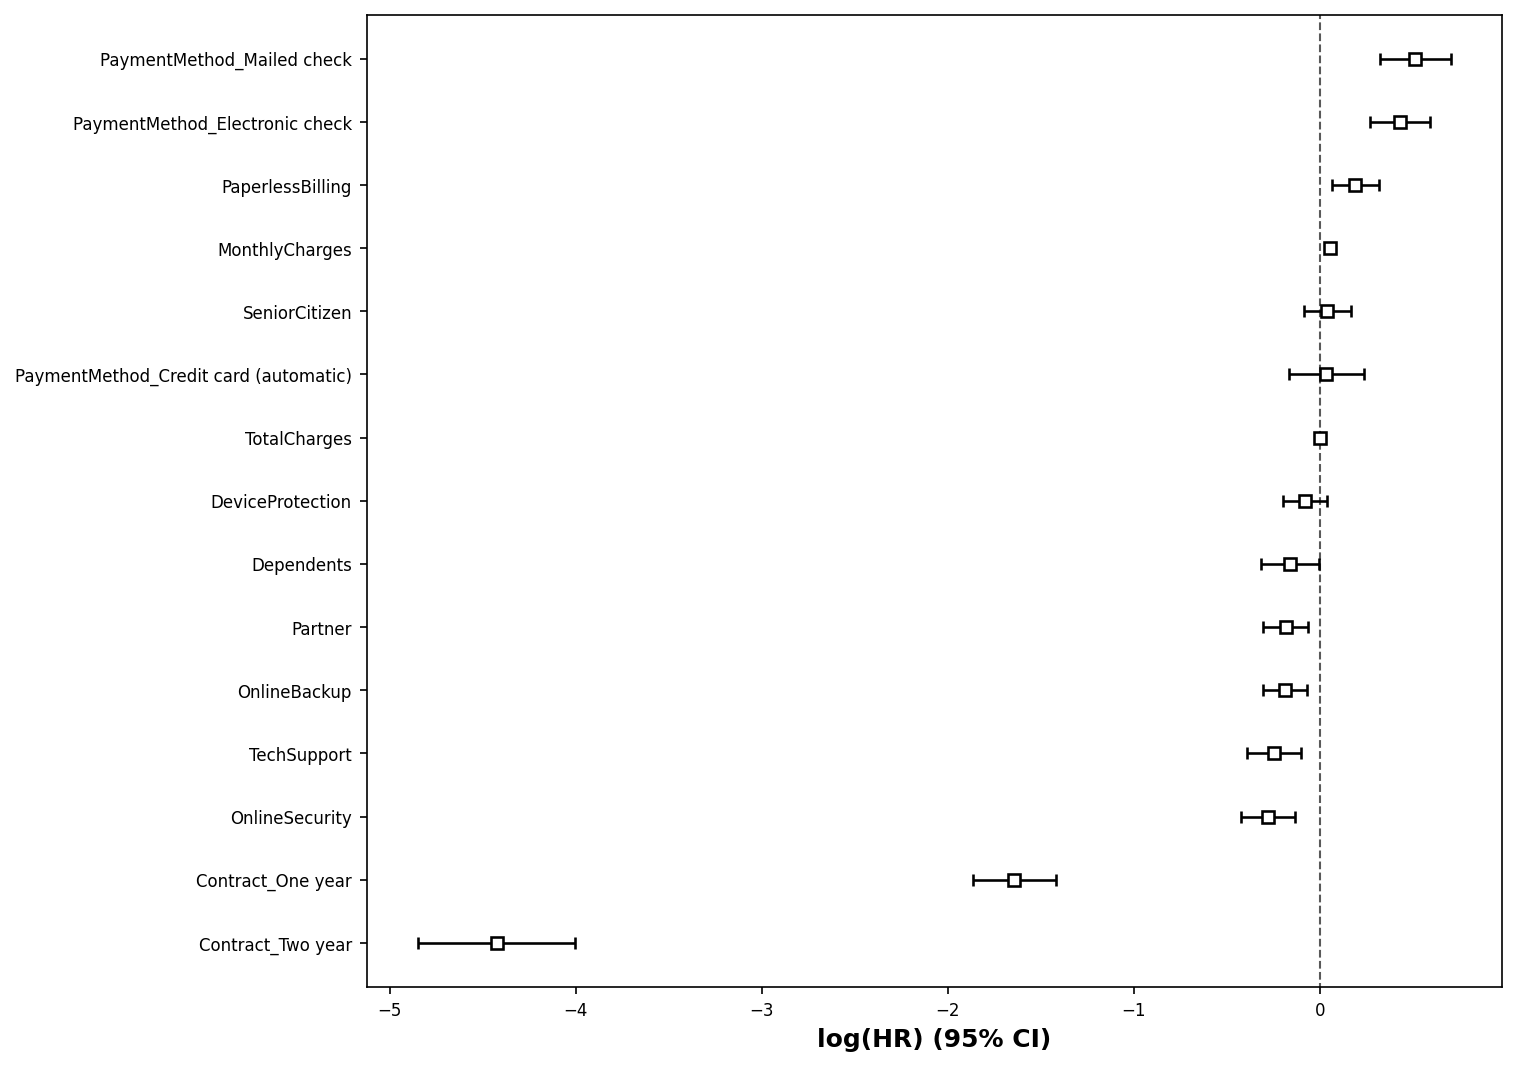

In [18]:
fig, ax = plt.subplots(figsize = (10,7))
cph.plot(ax = ax)

In [19]:
# cph.check_assumptions(train_regression, p_value_threshold=0.05, advice = False, show_plots=True)

## **Hyperparameter Tuning**

In [20]:
import optuna
def objective(trial):

    penalizer = trial.suggest_loguniform('penalizer', 1e-4, 1e4)
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    cph = CoxPHFitter(penalizer=penalizer, l1_ratio = l1_ratio)
    cph.fit(train_regression, duration_col='tenure', event_col='Churn', show_progress=False)

    # Calculate the log-likelihood score
    score = cph.log_likelihood_

    return score

# Create a study object and optimize the objective
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best parameters and best score
print_info('Optimization Summary',
           f'Best parameters: {study.best_params}',
           f'Best log-likelihood score: {study.best_value}')

[I 2023-10-04 13:20:02,109] A new study created in memory with name: no-name-98af207a-0dc8-4bc7-b648-4f1330ee6416
[I 2023-10-04 13:20:04,306] Trial 0 finished with value: -9834.744402819026 and parameters: {'penalizer': 0.001141680943348501, 'l1_ratio': 0.5515156195654786}. Best is trial 0 with value: -9834.744402819026.
[I 2023-10-04 13:20:06,628] Trial 1 finished with value: -31956.798000749706 and parameters: {'penalizer': 1293.102064573109, 'l1_ratio': 0.5792449080904428}. Best is trial 0 with value: -9834.744402819026.
[I 2023-10-04 13:20:08,535] Trial 2 finished with value: -10427.940276618281 and parameters: {'penalizer': 0.023752642357651742, 'l1_ratio': 0.13553998618570262}. Best is trial 0 with value: -9834.744402819026.
[I 2023-10-04 13:20:10,604] Trial 3 finished with value: -12330.883681762349 and parameters: {'penalizer': 833.4085144948266, 'l1_ratio': 0.09262639773942305}. Best is trial 0 with value: -9834.744402819026.
[I 2023-10-04 13:20:12,518] Trial 4 finished with v

--------------------
Optimization Summary
--------------------
Best parameters: {'penalizer': 0.00010014725998902696, 'l1_ratio': 0.9239065090808924}
Best log-likelihood score: -9783.077249031649


## **Refit with Optimal Hyperparameters**

In [21]:
tuned_params = study.best_params
tuned_cph = CoxPHFitter(**tuned_params)
tuned_cph.fit(train_regression, duration_col='tenure', event_col='Churn', show_progress=False)

<lifelines.CoxPHFitter: fitted with 5634 total observations, 4146 right-censored observations>

In [22]:
# tuned_cph.check_assumptions(train_regression, p_value_threshold=0.05, advice = False, show_plots=True)

## **Prediction**

In [23]:
pred_remaining_lifetime = tuned_cph.predict_median(test_regression)
pred_survival = tuned_cph.predict_survival_function(test_regression)
pred_cum_hazard = tuned_cph.predict_cumulative_hazard(test_regression)
pred_expected_lifetime = tuned_cph.predict_expectation(test_regression)

## **Plotting All Predictions**

In [24]:
def plot_prediction_summary(customer_id, survival_pred,
                            cum_hazard_pred, median_lifetime_pred, ax = None):
  if ax == None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 8))
  else:
    ax = ax

  if median_lifetime_pred[customer_id] == float('inf'):
    print(f'Customer {customer_id} has survival probability converging to infinity. Can not show on plot!')
  ax1.plot(cum_hazard_pred.index.astype(int) ,
               cum_hazard_pred.loc[:, customer_id])
  ax1.axvline(x=pred_cum_hazard.loc[:, customer_id].index.values[0],
             color = 'blue', linestyle='--')

  ax1.legend(labels=['Hazard','Current Position'])
  ax1.set_xlabel('Tenure')
  ax1.set_ylabel('Cumulative Hazard')
  ax1.set_title('Cumulative Hazard Over Time')

  ax2.plot(survival_pred.index.astype(int),
            survival_pred.loc[:, customer_id])
  ax2.axvline(x=survival_pred.loc[:, customer_id].index.values[0],
             color = 'blue', linestyle='--')
  ax2.axvline(x = median_lifetime_pred[customer_id], color = 'green',
              linestyle = '--')

  ax2.legend(labels=['Survival Function','Current Position',
                     'Median Remaining Lifetime'])
  ax2.set_xlabel('Tenure')
  ax2.set_ylabel('Survival Probability')
  ax2.set_title('Survival Probability Over Time')


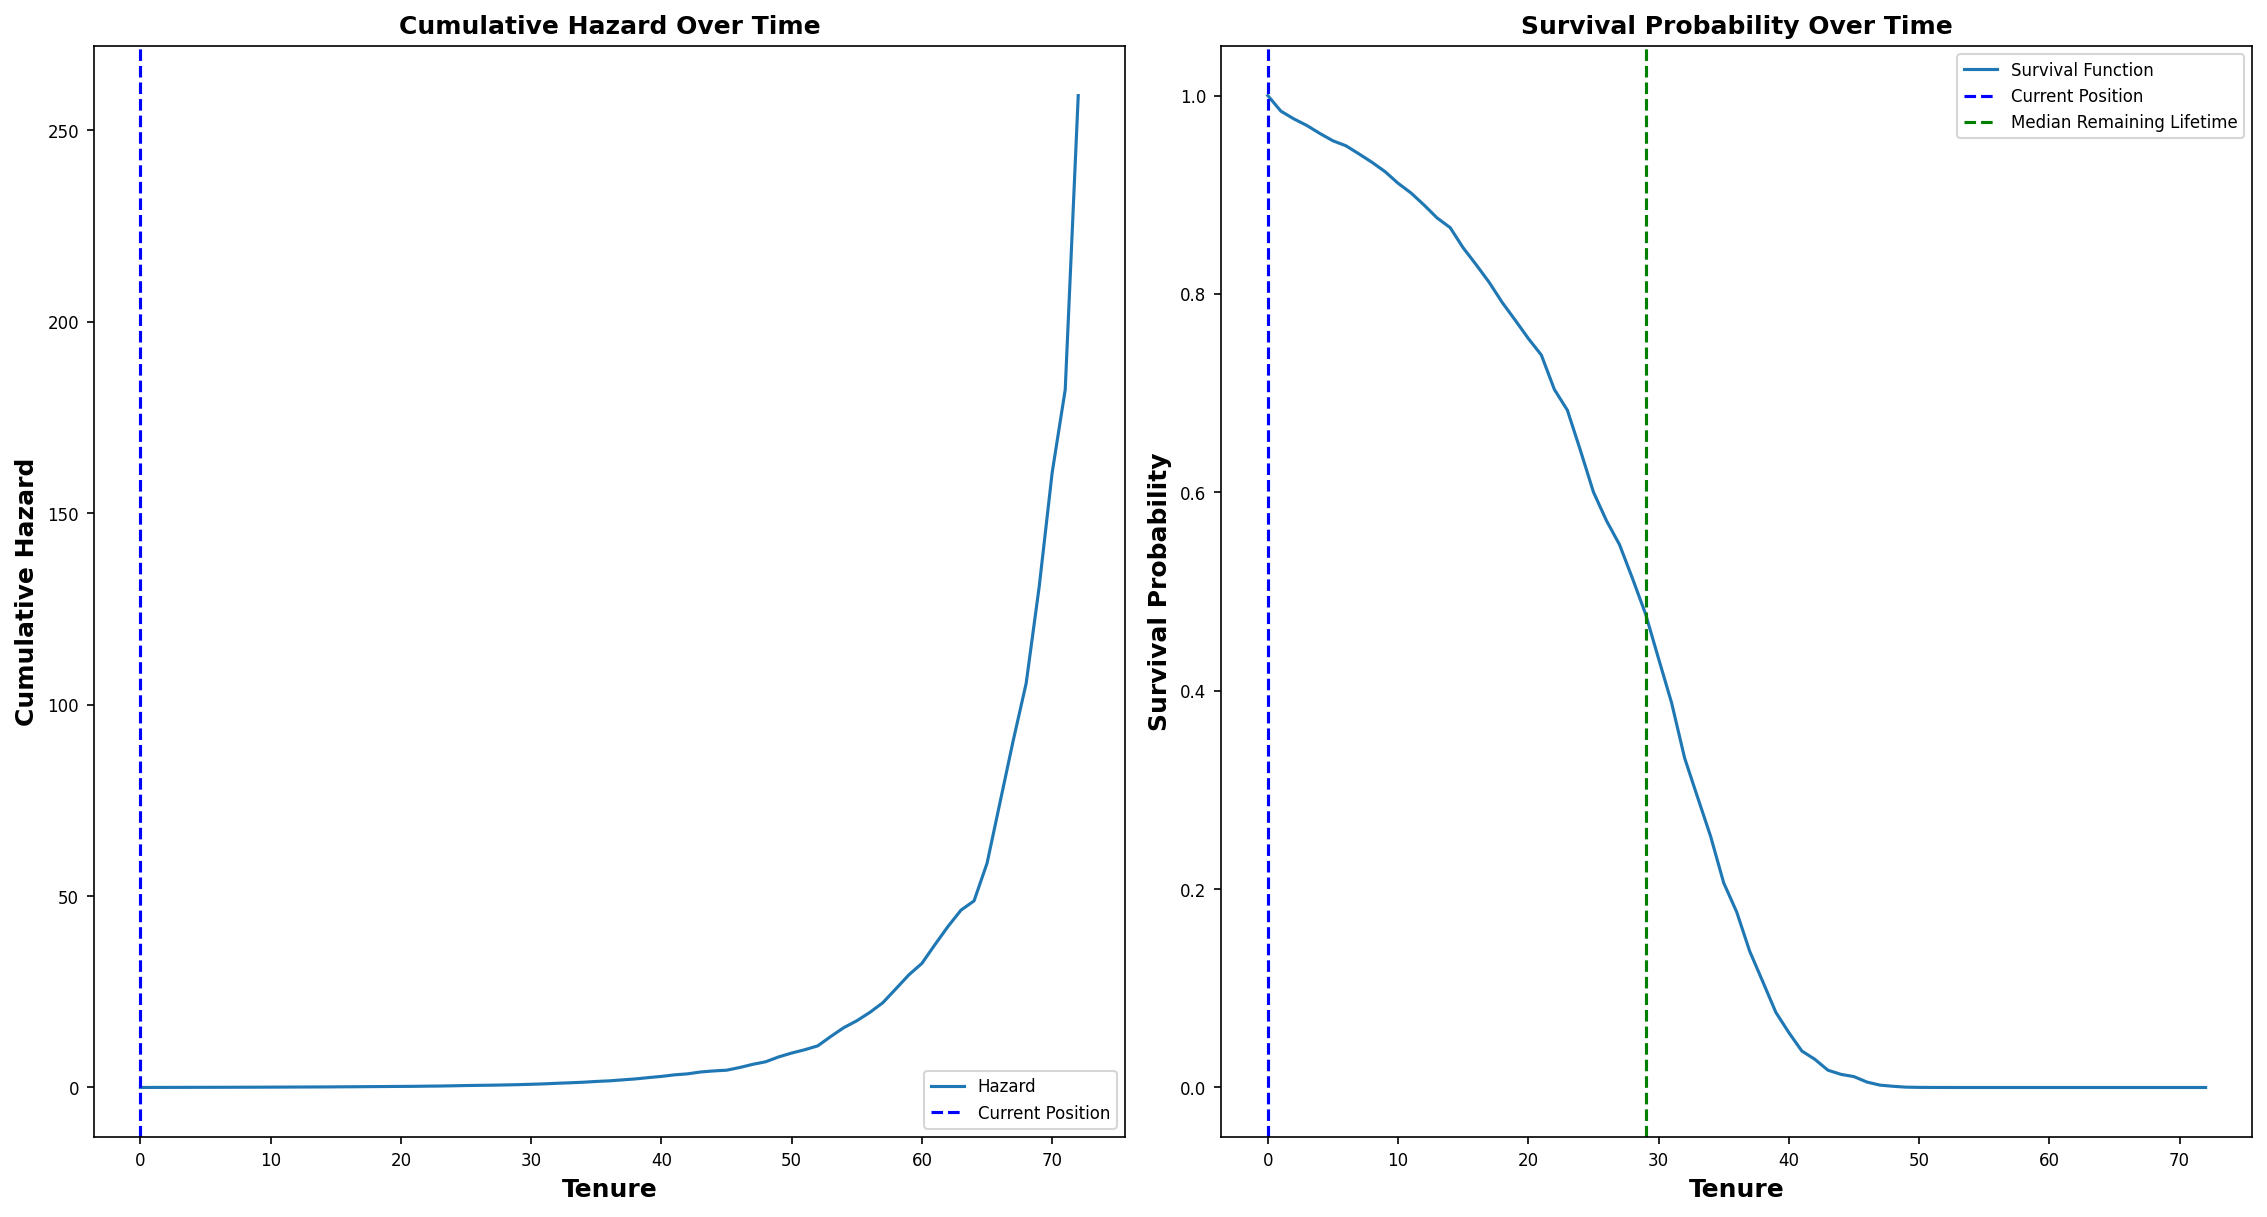

In [30]:
plot_prediction_summary(5634, pred_survival, pred_cum_hazard,
                        pred_remaining_lifetime)

## **Life Time Value based on Survival Analysis**

In [83]:
def LTV(method = 'remaining', customer_id = 5634):
  if method == 'remaining':
    max_life = pred_survival[pred_survival.loc[:, customer_id] > 0.1].index.max()

  if method == 'expected':
    max_life = pred_expected_lifetime[customer_id]
  LTV = max_life * test_regression.loc[customer_id, 'MonthlyCharges']
  return LTV

### **Specific Customer LTV Function**

In [84]:
customer_id =  test_regression.sample(1).index.values[0]
print(f'LTV of customer {customer_id} is: {round(LTV(customer_id = customer_id), 2)} dollars.')

LTV of customer 6221 is: 1136.8 dollars.


### **LTV for All Customers**

In [85]:
LTV_total_remain = [round(x, 2) for x in
                    list(map(lambda customer_id: LTV(method = 'remaining', customer_id = customer_id),
                             pred_survival.columns.values))]
LTV_total_expected= [round(x, 2) for x in
                     list(map(lambda customer_id: LTV(method = 'expected', customer_id = customer_id),
                              pred_survival.columns.values))]

LTV_df = pd.DataFrame({
    'customer_id': pred_survival.columns,
    'LTV_remain': LTV_total_remain,
    'LTV_expect': LTV_total_expected
})

In [86]:
LTV_df.head()

,customer_id,LTV_remain,LTV_expect
0,5634,756.20,525.32
1,5635,2023.90,1430.29
2,5636,1622.25,1079.10
3,5637,6498.00,6411.85
4,5638,718.20,500.43


### **Distribution of LTV**

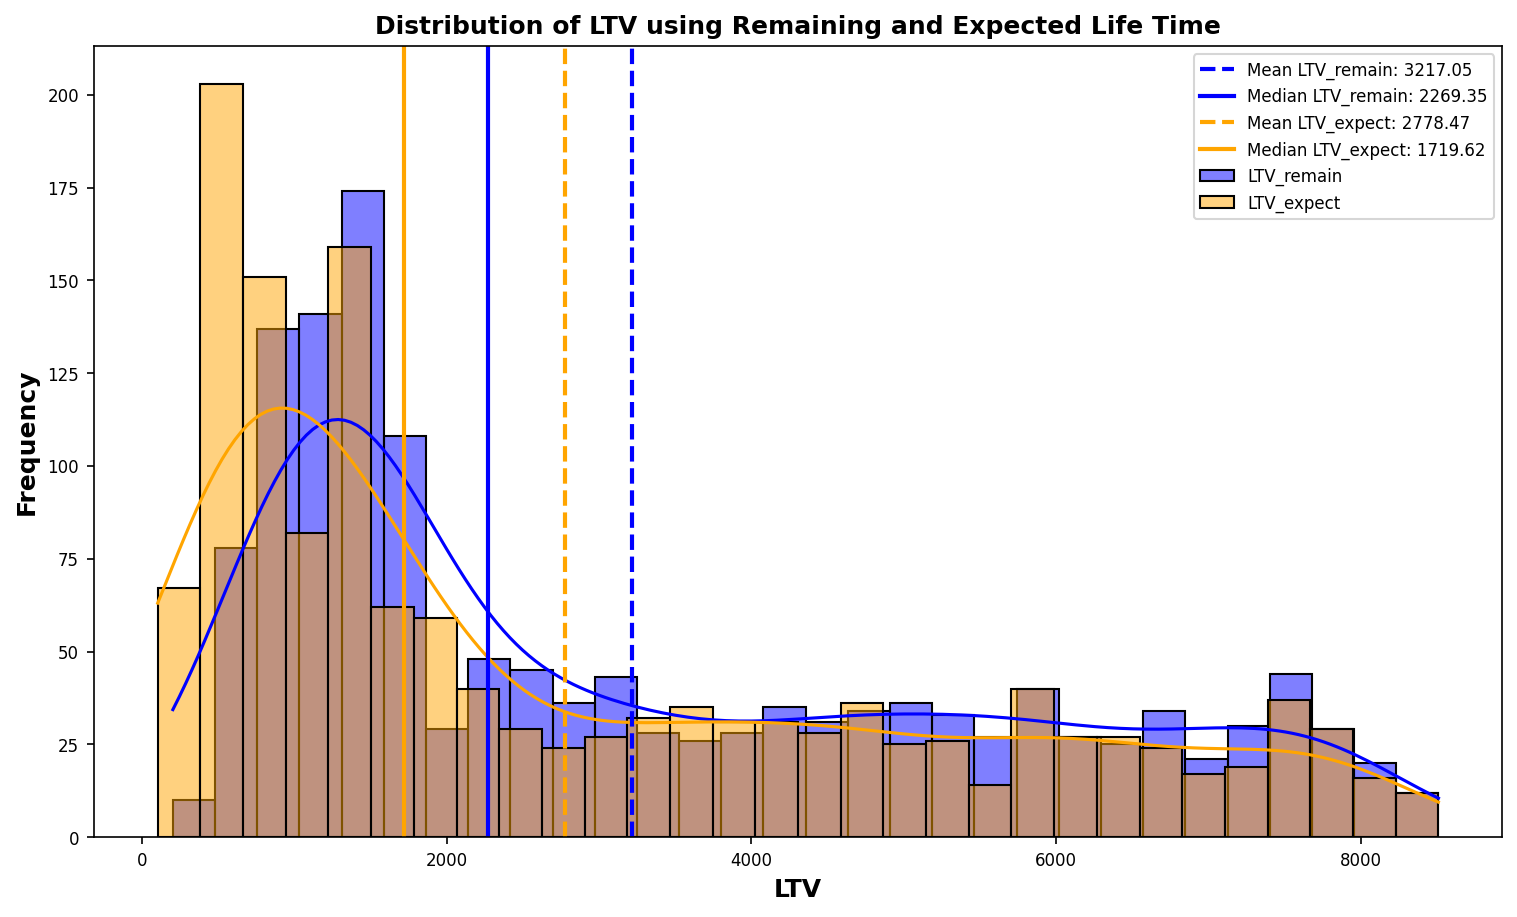

In [87]:
fig, ax = plt.subplots(figsize=(10,6))

# Plot histograms
sns.histplot(LTV_df, x='LTV_remain', bins=30, edgecolor='black',
             kde=True, color='blue', label='LTV_remain', ax=ax)
sns.histplot(LTV_df, x='LTV_expect', bins=30, edgecolor='black',
             kde=True, color='orange', label='LTV_expect', ax=ax)

# Calculate means and medians
mean_ltv_remain = LTV_df['LTV_remain'].mean()
median_ltv_remain = LTV_df['LTV_remain'].median()

mean_ltv_expect = LTV_df['LTV_expect'].mean()
median_ltv_expect = LTV_df['LTV_expect'].median()

# Plot mean and median lines for LTV_remain
ax.axvline(mean_ltv_remain, color='blue', linestyle='dashed',
           linewidth=2, label=f'Mean LTV_remain: {mean_ltv_remain:.2f}')
ax.axvline(median_ltv_remain, color='blue', linestyle='solid',
           linewidth=2, label=f'Median LTV_remain: {median_ltv_remain:.2f}')

# Plot mean and median lines for LTV_expect
ax.axvline(mean_ltv_expect, color='orange', linestyle='dashed',
           linewidth=2, label=f'Mean LTV_expect: {mean_ltv_expect:.2f}')
ax.axvline(median_ltv_expect, color='orange', linestyle='solid',
           linewidth=2, label=f'Median LTV_expect: {median_ltv_expect:.2f}')

# Set labels and title
ax.set_title('Distribution of LTV using Remaining and Expected Life Time')
ax.set_xlabel('LTV')
ax.set_ylabel('Frequency')

# Show legend
ax.legend()